In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D, LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping

/Users/harold.li/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/harold.li/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
"""
Returns the tau's to be predicted
"""
def get_output_data(prefix, suffix = 'T1'):
    tau_11 = loadmat(prefix + 'tau11_F_xyz_' + suffix + '.mat')['tau11']
    tau_12 = loadmat(prefix + 'tau12_F_xyz_' + suffix + '.mat')['tau12']
    tau_13 = loadmat(prefix + 'tau13_F_xyz_' + suffix + '.mat')['tau13']
    tau_22 = loadmat(prefix + 'tau22_F_xyz_' + suffix + '.mat')['tau22']
    tau_23 = loadmat(prefix + 'tau23_F_xyz_' + suffix + '.mat')['tau23']
    tau_33 = loadmat(prefix + 'tau33_F_xyz_' + suffix + '.mat')['tau33']
    
    tau_11 = np.pad(tau_11, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_12 = np.pad(tau_12, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_13 = np.pad(tau_13, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_22 = np.pad(tau_22, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_23 = np.pad(tau_23, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    tau_33 = np.pad(tau_33, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((0, 0), (0, 0), (0, 0)))
    
    return tau_11, tau_12, tau_13, tau_22, tau_23, tau_33

In [4]:
"""
Returns the tau's to be predicted
"""
def get_input_data(prefix, suffix = 'T1'):
    uf = loadmat(prefix + 'u_F_xyz_' + suffix + '.mat')['u_F']
    vf = loadmat(prefix + 'v_F_xyz_' + suffix + '.mat')['v_F']
    wf = loadmat(prefix + 'w_F_xyz_' + suffix + '.mat')['w_F']
    tke = loadmat(prefix + 'TKE_F_xyz_' + suffix + '.mat')['TKE_F']
    theta = loadmat(prefix + 'theta_F_xyz_' + suffix + '.mat')['theta_F']
    
    uf_mean, vf_mean, wf_mean, tke_mean, theta_mean = np.mean(uf), np.mean(vf), np.mean(wf), np.mean(tke), np.mean(theta)
    
    uf = np.pad(uf, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((uf_mean, uf_mean), (uf_mean, uf_mean), (uf_mean, uf_mean)))
    vf = np.pad(vf, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((vf_mean, vf_mean), (vf_mean, vf_mean), (vf_mean, vf_mean)))
    wf = np.pad(wf, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((wf_mean, wf_mean), (wf_mean, wf_mean), (wf_mean, wf_mean)))
    tke = np.pad(tke, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((tke_mean, tke_mean), (tke_mean, tke_mean), (tke_mean, tke_mean)))
    theta = np.pad(theta, ((1, 1), (1, 1), (1, 1)), 'constant', 
                    constant_values=((theta_mean, theta_mean), (theta_mean, theta_mean), (theta_mean, theta_mean)))

    return uf, vf, wf, tke, theta

In [5]:
"""
Denormalizes Outputs
"""
def denormalize_data_feng(train, valid, test):
    mu, std = np.mean(train.flatten()), np.std(train.flatten())
    train_new = (train - mu)/std
    valid_new = (valid - mu)/std
    test_new = (test - mu)/std
    print()
    return train_new, valid_new, test_new, mu, std

In [6]:
"""
Denormalizes Outputs
"""
def denormalize_data_feng_mu_std(train, test, mu, std):
    #mu, std = np.mean(train.flatten()), np.std(train.flatten())
    train_new = (train - mu)/std
    test_new = (test - mu)/std
    print()
    return train_new, test_new

In [7]:
"""
Reshapes Data and split data into train, validation and test sets (Convolutional & Feng Set up)
"""
def create_train_test_sets_conv3d_feng(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                                       uf, vf, wf, tke, theta,
                                       size = 3):
    
    train_index = np.concatenate((np.ones((int(uf.shape[0]*1/2), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                                  np.zeros((int(uf.shape[0]*1/2), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                                 axis = 0)
    valid_index = np.concatenate((np.zeros((int(uf.shape[0]*1/2), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                                  np.ones((int(uf.shape[0]*1/4), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                                  np.zeros((int(uf.shape[0]*1/4), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                                 axis = 0)
    test_index = np.concatenate((np.zeros((int(uf.shape[0]*3/4), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                                 np.ones((int(uf.shape[0]*1/4), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                                 axis = 0)
    
    print(train_index.shape)
    
    offset_size = int(size/2)
    
    for idx in range(8):
        
        scaled_idx = int(idx * uf.shape[0]/8)
        scaled_idx_end = int((idx + 1) * uf.shape[0]/8)
        
        train_index[scaled_idx:(scaled_idx+offset_size),:,:] = False
        train_index[(scaled_idx_end-offset_size):(scaled_idx_end),:,:] = False
        train_index[:,0:(0+offset_size),:] = False
        train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
        train_index[:,:,0:(0+offset_size)] = False
        train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
        
        test_index[scaled_idx:(scaled_idx+offset_size),:,:] = False
        test_index[(scaled_idx_end-offset_size):(scaled_idx_end),:,:] = False
        test_index[:,0:(0+offset_size),:] = False
        test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
        test_index[:,:,0:(0+offset_size)] = False
        test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
        
        valid_index[scaled_idx:(scaled_idx+offset_size),:,:] = False
        valid_index[(scaled_idx_end-offset_size):(scaled_idx_end),:,:] = False
        valid_index[:,0:(0+offset_size),:] = False
        valid_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
        valid_index[:,:,0:(0+offset_size)] = False
        valid_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_index[:,:,55:] = False
    valid_index[:,:,55:] = False
    test_index[:,:,55:] = False
    
    train_locs = np.where(train_index)
    valid_locs = np.where(valid_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    tau_11_train, tau_11_valid, tau_11_test = np.transpose([tau_11[train_locs]]), np.transpose([tau_11[valid_locs]]), np.transpose([tau_11[test_locs]])
    tau_12_train, tau_12_valid, tau_12_test = np.transpose([tau_12[train_locs]]), np.transpose([tau_12[valid_locs]]), np.transpose([tau_12[test_locs]])
    tau_13_train, tau_13_valid, tau_13_test = np.transpose([tau_13[train_locs]]), np.transpose([tau_13[valid_locs]]), np.transpose([tau_13[test_locs]])
    tau_22_train, tau_22_valid, tau_22_test = np.transpose([tau_22[train_locs]]), np.transpose([tau_22[valid_locs]]), np.transpose([tau_22[test_locs]])
    tau_23_train, tau_23_valid, tau_23_test = np.transpose([tau_23[train_locs]]), np.transpose([tau_23[valid_locs]]), np.transpose([tau_23[test_locs]])
    tau_33_train, tau_33_valid, tau_33_test = np.transpose([tau_33[train_locs]]), np.transpose([tau_33[valid_locs]]), np.transpose([tau_33[test_locs]])
    
    tau_11_train, tau_11_valid, tau_11_test, mu_11, std_11 = denormalize_data_feng(tau_11_train, tau_11_valid, tau_11_test)
    tau_12_train, tau_12_valid, tau_12_test, mu_12, std_12 = denormalize_data_feng(tau_12_train, tau_12_valid, tau_12_test)
    tau_13_train, tau_13_valid, tau_13_test, mu_13, std_13 = denormalize_data_feng(tau_13_train, tau_13_valid, tau_13_test)
    tau_22_train, tau_22_valid, tau_22_test, mu_22, std_22 = denormalize_data_feng(tau_22_train, tau_22_valid, tau_22_test)
    tau_23_train, tau_23_valid, tau_23_test, mu_23, std_23 = denormalize_data_feng(tau_23_train, tau_23_valid, tau_23_test)
    tau_33_train, tau_33_valid, tau_33_test, mu_33, std_33 = denormalize_data_feng(tau_33_train, tau_33_valid, tau_33_test)
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])
    
    x_valid = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(valid_locs[0], valid_locs[1], valid_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])
    
    x_normalized = [denormalize_data_feng(x_train[:,:,:,:,k], x_valid[:,:,:,:,k], x_test[:,:,:,:,k]) 
                    for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_valid = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[2] for k in x_normalized], axis = 4)) 
    
    x_mu = np.array([k[3] for k in x_normalized])
    x_std = np.array([k[4] for k in x_normalized])        
    
    print('X_train shape', x_train.shape)
    print('tau_train shape', tau_11_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_valid, x_test, tau_11_train, tau_11_valid, tau_11_test, 
            tau_12_train, tau_12_valid, tau_12_test, tau_13_train, tau_13_valid, tau_13_test,
           tau_22_train, tau_22_valid, tau_22_test, tau_23_train, tau_23_valid, tau_23_test, 
            tau_33_train, tau_33_valid, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33, x_mu, x_std)

In [8]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_conv_3d_model_feng(x_train, x_valid, x_test, y_train, y_valid, y_test, act_func = 'tanh',
                          batch_size = 1024, epochs = 20, num_nodes = 6, xdim = 3, size = 3):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
        
    model = Sequential()
    
    model.add(Conv3D(128, kernel_size = (size,size,size), data_format = 'channels_last',
                         input_shape = x_train[...,:xdim].shape[1:], kernel_initializer = 'random_uniform'))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = final_act_func))
    
    callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]
    model.summary()

    model.compile(loss='mse',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train[...,:xdim], y_train[...,:xdim],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_valid[...,:xdim], y_valid[...,:xdim]),
                        callbacks = callback)
    score = model.evaluate(x_test[...,:xdim], y_test[...,:xdim], verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [9]:
"""
Plots Actual vs. Predicted Values from Model
"""
def visualize(model, x_test, y_test, mu, std):
    y_predict = model.predict(x_test)
    sample_index = (np.random.rand(y_test.shape[0]) < 1000./y_test.shape[0])
    plt.figure(figsize=(15,5))
    plt.plot(y_test[sample_index]*std+mu)
    plt.plot(y_predict[sample_index]*std+mu)
    plt.show()

In [10]:
models = {'conv-3d NN Feng': (create_train_test_sets_conv3d_feng, train_conv_3d_model_feng)}

In [11]:
"""
Plots Actual vs. Predicted Values from Model
"""
def predict(model, x_test, y_test, mu, std):
    y_test = y_test.flatten()*std + mu
    y_predict = model.predict(x_test).flatten()*std + mu
    return np.corrcoef(y_test, y_predict), np.sqrt(((y_test - y_predict) ** 2).mean())

In [12]:
"""
Main Function to Execute Model
"""
def main_feng(model_name, size = 3, xdim = 6):
    
    # Output Data
    tau_11_1, tau_12_1, tau_13_1, tau_22_1, tau_23_1, tau_33_1 = get_output_data('Re15sh20_DNScoarse8/', suffix = 'T1')
    tau_11_2, tau_12_2, tau_13_2, tau_22_2, tau_23_2, tau_33_2 = get_output_data('Re15sh20_DNScoarse8_T2/', suffix = 'T2')
    tau_11_3, tau_12_3, tau_13_3, tau_22_3, tau_23_3, tau_33_3 = get_output_data('Re15sh20_DNScoarse8_T3/', suffix = 'T3')
    tau_11_4, tau_12_4, tau_13_4, tau_22_4, tau_23_4, tau_33_4 = get_output_data('Re15sh20_DNScoarse8_T4/', suffix = 'T4')
    tau_11_5, tau_12_5, tau_13_5, tau_22_5, tau_23_5, tau_33_5 = get_output_data('Re15sh20_DNScoarse8_T5/', suffix = 'T5')
    tau_11_6, tau_12_6, tau_13_6, tau_22_6, tau_23_6, tau_33_6 = get_output_data('Re15sh20_DNScoarse8_T6/', suffix = 'T6')
    tau_11_7, tau_12_7, tau_13_7, tau_22_7, tau_23_7, tau_33_7 = get_output_data('Re15sh20_DNScoarse8_T7/', suffix = 'T7')
    tau_11_8, tau_12_8, tau_13_8, tau_22_8, tau_23_8, tau_33_8 = get_output_data('Re15sh20_DNScoarse8_T8/', suffix = 'T8')
    
    tau_11 = np.concatenate([tau_11_1, tau_11_2, tau_11_3, tau_11_4, tau_11_5, tau_11_6, tau_11_7, tau_11_8],
                            axis = 0)
    tau_12 = np.concatenate([tau_12_1, tau_12_2, tau_12_3, tau_12_4, tau_12_5, tau_12_6, tau_12_7, tau_12_8],
                            axis = 0)
    tau_13 = np.concatenate([tau_13_1, tau_13_2, tau_13_3, tau_13_4, tau_13_5, tau_13_6, tau_13_7, tau_13_8],
                            axis = 0)
    tau_22 = np.concatenate([tau_22_1, tau_22_2, tau_22_3, tau_22_4, tau_22_5, tau_22_6, tau_22_7, tau_22_8],
                            axis = 0)
    tau_23 = np.concatenate([tau_23_1, tau_23_2, tau_23_3, tau_23_4, tau_23_5, tau_23_6, tau_23_7, tau_23_8],
                            axis = 0)
    tau_33 = np.concatenate([tau_33_1, tau_33_2, tau_33_3, tau_33_4, tau_33_5, tau_33_6, tau_33_7, tau_33_8],
                            axis = 0)
    
    print('Shape of Output Files:')
    print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)
    
    # Input Data
    uf_1, vf_1, wf_1, tke_1, theta_1 = get_input_data('Re15sh20_DNScoarse8/', suffix = 'T1')
    uf_2, vf_2, wf_2, tke_2, theta_2 = get_input_data('Re15sh20_DNScoarse8_T2/', suffix = 'T2')
    uf_3, vf_3, wf_3, tke_3, theta_3 = get_input_data('Re15sh20_DNScoarse8_T3/', suffix = 'T3')
    uf_4, vf_4, wf_4, tke_4, theta_4 = get_input_data('Re15sh20_DNScoarse8_T4/', suffix = 'T4')
    uf_5, vf_5, wf_5, tke_5, theta_5 = get_input_data('Re15sh20_DNScoarse8_T5/', suffix = 'T5')
    uf_6, vf_6, wf_6, tke_6, theta_6 = get_input_data('Re15sh20_DNScoarse8_T6/', suffix = 'T6')
    uf_7, vf_7, wf_7, tke_7, theta_7 = get_input_data('Re15sh20_DNScoarse8_T7/', suffix = 'T7')
    uf_8, vf_8, wf_8, tke_8, theta_8 = get_input_data('Re15sh20_DNScoarse8_T8/', suffix = 'T8')
    
    uf = np.concatenate([uf_1, uf_2, uf_3, uf_4, uf_5, uf_6, uf_7, uf_8], 
                         axis = 0)
    vf = np.concatenate([vf_1, vf_2, vf_3, vf_4, vf_5, vf_6, vf_7, vf_8], 
                         axis = 0)
    wf = np.concatenate([wf_1, wf_2, wf_3, wf_4, wf_5, wf_6, wf_7, wf_8], 
                         axis = 0)
    tke = np.concatenate([tke_1, tke_2, tke_3, tke_4, tke_5, tke_6, tke_7, tke_8], 
                         axis = 0)
    theta = np.concatenate([theta_1, theta_2, theta_3, theta_4, theta_5, theta_6, theta_7, theta_8], 
                         axis = 0)
    
    print('Shape of Input Files:')
    print(wf.shape)
        
    # Explore Data
    #explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_valid, x_test, tau_11_train, tau_11_valid, tau_11_test, 
            tau_12_train, tau_12_valid, tau_12_test, tau_13_train, tau_13_valid, tau_13_test,
           tau_22_train, tau_22_valid, tau_22_test, tau_23_train, tau_23_valid, tau_23_test, 
            tau_33_train, tau_33_valid, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, 
     mu_22, std_22, mu_23, std_23, mu_33, std_33, x_mu, x_std) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                       tau_33, uf, vf, wf, tke, theta, size = size)
    
    print(x_train.shape)
    print(x_mu)
    print(x_std)
    
    # Train the Model
    models_final = [model_func(x_train, x_valid, x_test, tau_11_train, tau_11_valid, tau_11_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_12_train, tau_12_valid, tau_12_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_13_train, tau_13_valid, tau_13_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_22_train, tau_22_valid, tau_22_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_23_train, tau_23_valid, tau_23_test, 
                               act_func = 'relu', size = size, xdim = xdim),
                    model_func(x_train, x_valid, x_test, tau_33_train, tau_33_valid, tau_33_test, 
                               act_func = 'relu', size = size, xdim = xdim)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test[...,:xdim], tau_11_test, mu_11, std_11),
               predict(models_final[1], x_test[...,:xdim], tau_12_test, mu_12, std_12),
               predict(models_final[2], x_test[...,:xdim], tau_13_test, mu_13, std_13),
               predict(models_final[3], x_test[...,:xdim], tau_22_test, mu_22, std_22),
               predict(models_final[4], x_test[...,:xdim], tau_23_test, mu_23, std_23),
               predict(models_final[5], x_test[...,:xdim], tau_33_test, mu_33, std_33)]
    
    visualize(models_final[0], x_test[...,:xdim], tau_11_test, mu_11, std_11)
    visualize(models_final[1], x_test[...,:xdim], tau_12_test, mu_12, std_12)
    visualize(models_final[2], x_test[...,:xdim], tau_13_test, mu_13, std_13)
    visualize(models_final[3], x_test[...,:xdim], tau_22_test, mu_22, std_22)
    visualize(models_final[4], x_test[...,:xdim], tau_23_test, mu_23, std_23)
    visualize(models_final[5], x_test[...,:xdim], tau_33_test, mu_33, std_33)
    
    print(results)
    
    return models_final, results, x_mu, x_std
    

# Train on Re15sh20_DNScoarse8 Only

Shape of Output Files:
(1184, 98, 77) (1184, 98, 77) (1184, 98, 77) (1184, 98, 77) (1184, 98, 77) (1184, 98, 77)
Shape of Input Files:
(1184, 98, 77)
(1184, 98, 77)
(array([  1,   1,   1, ..., 590, 590, 590]), array([ 1,  1,  1, ..., 96, 96, 96]), array([ 1,  2,  3, ..., 52, 53, 54]))











X_train shape (3027456, 3, 3, 3, 5)
tau_train shape (3027456, 1)
3027456 train samples
1513728 test samples
(3027456, 3, 3, 3, 5)
[9.52893629e-01 8.94909770e-03 5.00827497e-04 4.95693562e-03
 1.33980408e-04]
[7.22337985e-02 5.06366643e-02 6.86197485e-02 6.31552524e-03
 2.07452646e-06]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 1, 1, 1, 128)      10496     
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)  

3027456/3027456 [==============================] - 3452s 1ms/step - loss: 0.1676 - mean_squared_error: 0.1676 - val_loss: 0.1812 - val_mean_squared_error: 0.1812
Epoch 4/20
3027456/3027456 [==============================] - 3432s 1ms/step - loss: 0.1608 - mean_squared_error: 0.1608 - val_loss: 0.1728 - val_mean_squared_error: 0.1728
Epoch 5/20
3027456/3027456 [==============================] - 3443s 1ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - val_loss: 0.1763 - val_mean_squared_error: 0.1763
Test loss: 0.1917622148973526
Test accuracy: 0.1917622148973526
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 1, 1, 1, 128)      10496     
_________________________________________________________________
activation_5 (Activation)    (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_5 (Flatten)          (No

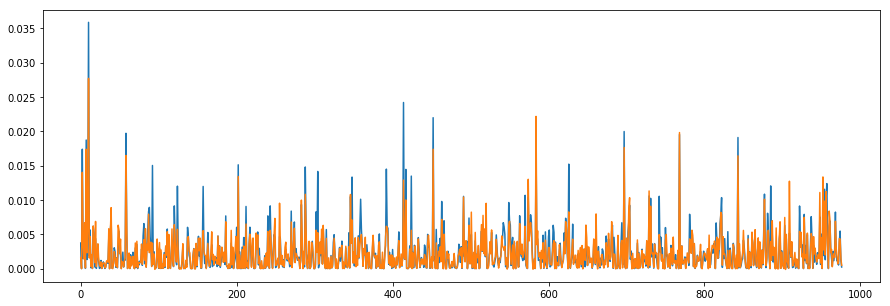

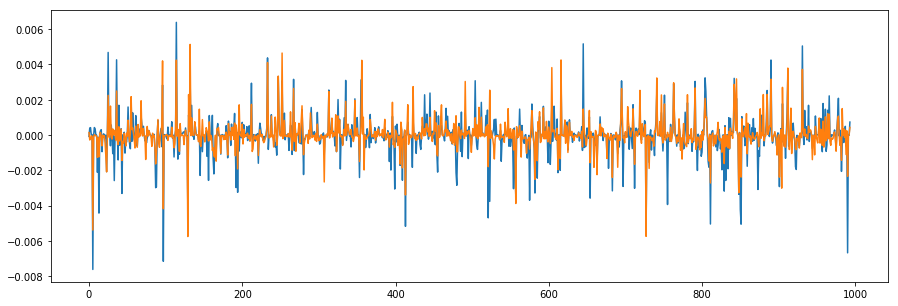

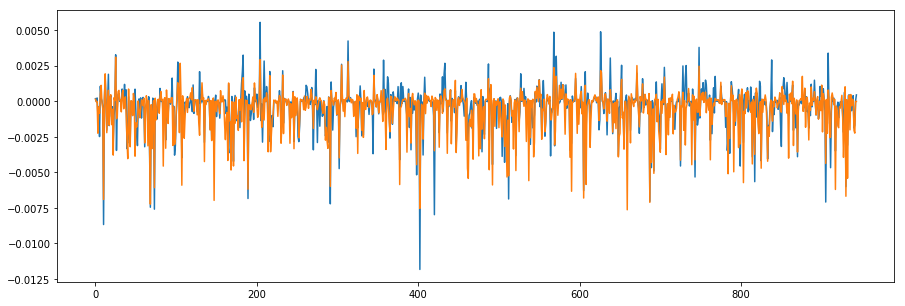

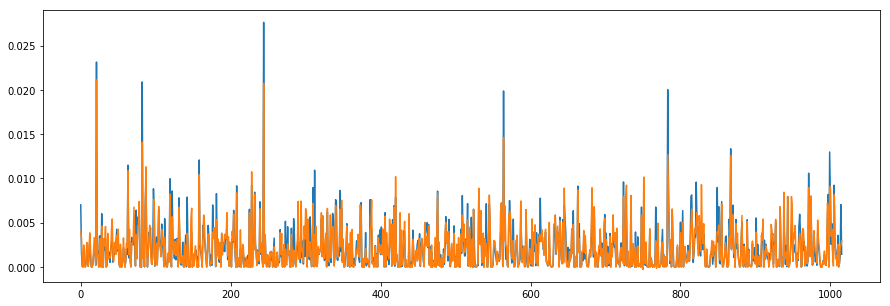

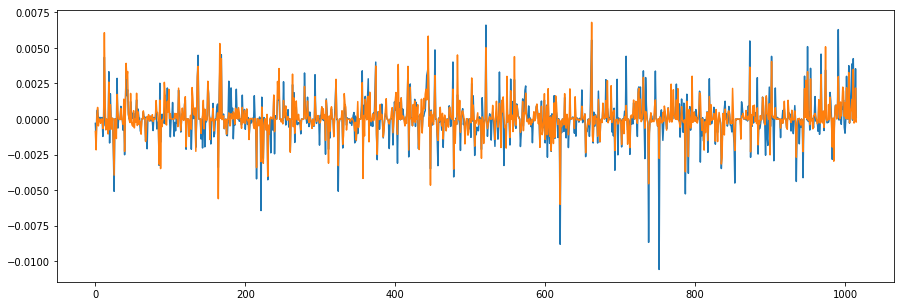

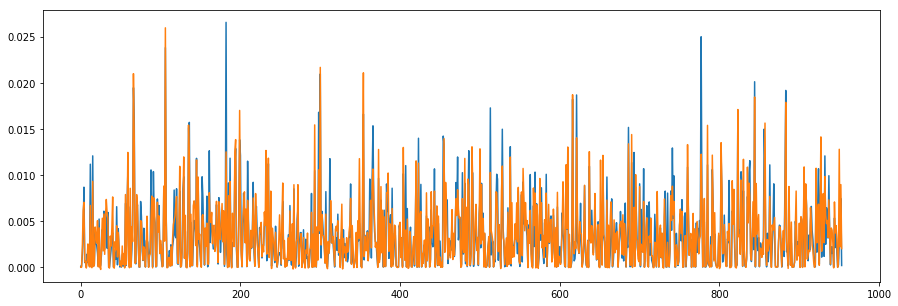

ValueError: too many values to unpack (expected 2)

In [13]:
model_conv_3d_feng, results_conv_3d_feng, x_mu, x_std = main_feng('conv-3d NN Feng', 3, 3)

In [310]:
results_conv_3d_feng

[(array([[1.        , 0.90170951],
         [0.90170951, 1.        ]]), 0.0013106266543058854),
 (array([[1.        , 0.74754913],
         [0.74754913, 1.        ]]), 0.0006750459647559184),
 (array([[1.        , 0.82255794],
         [0.82255794, 1.        ]]), 0.000922579822780932),
 (array([[1.       , 0.9186857],
         [0.9186857, 1.       ]]), 0.0010003498125603358),
 (array([[1.        , 0.79203864],
         [0.79203864, 1.        ]]), 0.0007913823856986481),
 (array([[1.        , 0.89950168],
         [0.89950168, 1.        ]]), 0.0017076960760629186)]

## Code to Run to Predict on Other Datasets

In [216]:
# Output Data
model_name, size, augmentation, xdim,  prefix = 'conv-3d NN Feng', 3, None, 6, 'Re15sh20_DNScoarse8/'

tau_11, tau_12, tau_13, tau_22, tau_23, tau_33 = get_output_data(prefix)
print('Shape of Output Files:')
print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)

# Input Data
uf, vf, wf, tke, theta, grad = get_input_data(prefix)
print('Shape of Input Files:')
print(wf.shape)
    
# Explore Data
#explore_data(tau_12)

# Get Functions
train_test_split_func, model_func = models[model_name]

# Reshape Data and Get Train/Test Sets
(_, _, _, _, _, _, 
 _, _, _, _, _, _, 
 _, _, _, _, _, _, 
 _, _, _,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33, x_mu, x_std) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                   tau_33, uf, vf, wf, tke, theta, grad,
                                                                      train_pct = 0.5, size = size,
                                                                     augmentation = augmentation)

Shape of Output Files:
(148, 98, 77) (148, 98, 77) (148, 98, 77) (148, 98, 77) (148, 98, 77) (148, 98, 77)
Shape of Input Files:
(148, 98, 77)
(148, 98, 77)
(array([  1,   1,   1, ..., 146, 146, 146]), array([33, 33, 33, ..., 96, 96, 96]), array([ 1,  2,  3, ..., 52, 53, 54]))












X_train shape (504576, 3, 3, 3, 6)
tau_train shape (504576, 1)
504576 train samples
126144 test samples


In [407]:
# Output Data - CHANGE DATASET NAME HERE
model_name, size, augmentation, xdim,  prefix = 'conv-3d NN Feng', 3, None, 6, 'Re15sh20_DNScoarse16/'

tau_11, tau_12, tau_13, tau_22, tau_23, tau_33 = get_output_data(prefix)
print('Shape of Output Files:')
print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)

# Input Data
uf, vf, wf, tke, theta, grad = get_input_data(prefix)
print('Shape of Input Files:')
print(wf.shape)
    
# Explore Data
#explore_data(tau_12)

# Get Functions
train_test_split_func, model_func = models[model_name]

# Reshape Data and Get Train/Test Sets
(x_train, _, x_test, tau_11_train, _, tau_11_test, 
 tau_12_train, _, tau_12_test, tau_13_train, _, tau_13_test,
 tau_22_train, _, tau_22_test, tau_23_train, _, tau_23_test, tau_33_train, _, tau_33_test,
 _, _, _, _, _, _, 
 _, _, _, _, _, _,_,_) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                   tau_33, uf, vf, wf, tke, theta, grad,
                                                                      train_pct = 0.5, size = size,
                                                                     augmentation = augmentation)

Shape of Output Files:
(73, 48, 38) (73, 48, 38) (73, 48, 38) (73, 48, 38) (73, 48, 38) (73, 48, 38)
Shape of Input Files:
(73, 48, 38)
(73, 48, 38)
(array([ 1,  1,  1, ..., 71, 71, 71]), array([ 1,  1,  1, ..., 46, 46, 46]), array([ 1,  2,  3, ..., 25, 26, 27]))












X_train shape (88182, 3, 3, 3, 6)
tau_train shape (88182, 1)
88182 train samples
88182 test samples


In [408]:
#x_normalized = [denormalize_data_feng_mu_std(x_train[:,:,:,:,k], x_test[:,:,:,:,k], x_mu[k], x_std[k]) 
#                    for k in range(x_train.shape[4])]
#x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
#x_test = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    
import scipy
y_test, model, mu, std = tau_11_test, model_conv_3d_feng[0], mu_11, std_11

y_test = y_test.flatten()
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_12_test, model_conv_3d_feng[1], mu_12, std_12

y_test = y_test.flatten()
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

scipy.io.savemat(prefix + 'tau_12_predict_new.mat', 
                 mdict={'tau_12': y_predict.reshape(uf.shape[0]-2,uf.shape[1]-2,int((uf.shape[2]-2)*3/4))})

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_13_test, model_conv_3d_feng[2], mu_13, std_13

y_test = y_test.flatten()
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

scipy.io.savemat(prefix + 'tau_13_predict_new.mat', 
                 mdict={'tau_13': y_predict.reshape(uf.shape[0]-2,uf.shape[1]-2,int((uf.shape[2]-2)*3/4))})


print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_22_test, model_conv_3d_feng[3], mu_22, std_22

y_test = y_test.flatten()
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_23_test, model_conv_3d_feng[4], mu_23, std_23

y_test = y_test.flatten()
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

scipy.io.savemat(prefix + 'tau_23_predict_new.mat', 
                 mdict={'tau_23': y_predict.reshape(uf.shape[0]-2,uf.shape[1]-2,int((uf.shape[2]-2)*3/4))})

print(np.corrcoef(y_test, y_predict))

y_test, model, mu, std = tau_33_test, model_conv_3d_feng[5], mu_33, std_33

y_test = y_test.flatten()
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

print(np.corrcoef(y_test, y_predict))

[[1.         0.77411096]
 [0.77411096 1.        ]]
[[1.       0.543498]
 [0.543498 1.      ]]
[[1.         0.70769903]
 [0.70769903 1.        ]]
[[1.         0.89536621]
 [0.89536621 1.        ]]
[[1.         0.73237895]
 [0.73237895 1.        ]]
[[1.         0.82720598]
 [0.82720598 1.        ]]


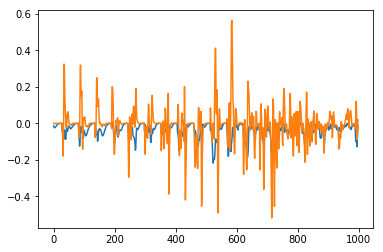

In [369]:
#y_test, model, mu, std = tau_13_test, model_conv_3d_feng[2], mu_13, std_13

#y_test = y_test.flatten()*std + mu
#y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

plt.plot(y_predict[-1000:-1])
plt.plot(y_test[-1000:-1])

# Extras

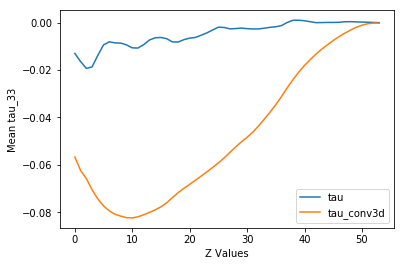

In [368]:
y_test, model, mu, std = tau_13_test, model_conv_3d_feng[2], mu_13, std_13

y_test = y_test.flatten()
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

y_test_final = y_test.reshape((71, 46, 27))
y_predict_final = y_predict.reshape((146, 96, 54))

y_test_z_mean = np.mean(y_test_final, axis = (0,1))
y_predict_z_mean = np.mean(y_predict_final, axis = (0,1))

plt.plot(range(54), y_test_z_mean)
plt.plot(range(54), y_predict_z_mean)
plt.legend(['tau','tau_conv3d'])
plt.xlabel('Z Values')
plt.ylabel('Mean tau_33')
plt.show()

In [409]:
y_test, model, mu, std = tau_23_test, model_conv_3d_feng[4], mu_23, std_23

y_test = y_test.flatten()*std + mu
y_predict = model.predict(x_test[...,:xdim]).flatten()*std + mu

y_test_final = y_test.reshape((71, 46, 27))
y_predict_final = y_predict.reshape((71, 46, 27))

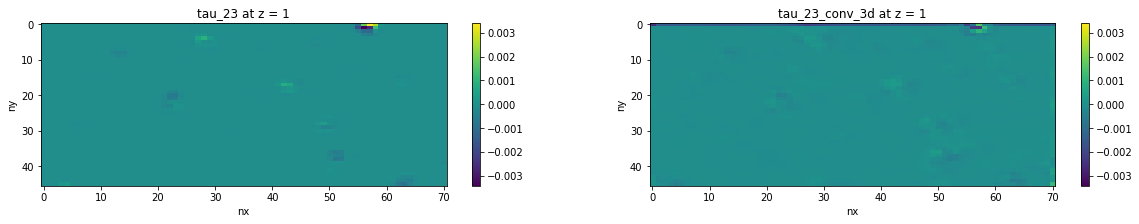

In [417]:
vmin, vmax = -1*np.max(np.abs(y_test_final[:,:,25])), np.max(np.abs(y_test_final[:,:,25]))

plt.figure(1, figsize = (20,3))
plt.subplot(121)
plt.imshow(np.transpose(y_test_final[:,:,25]), vmin=vmin, vmax=vmax, aspect = 'auto')
plt.title('tau_23 at z = 1')
plt.xlabel('nx')
plt.ylabel('ny')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.transpose(y_predict_final[:,:,25]), vmin=vmin, vmax=vmax, aspect = 'auto')
plt.colorbar()
plt.title('tau_23_conv_3d at z = 1')
plt.xlabel('nx')
plt.ylabel('ny')
plt.show()

In [418]:
y_test_final[:,0,25]

array([-4.64512706e-05, -4.68367674e-05, -4.72265604e-05, -4.49411906e-05,
       -3.71747888e-05, -3.45174687e-05, -3.95226481e-05, -4.70320309e-05,
       -4.72025435e-05, -4.67193957e-05, -4.63951108e-05, -4.65569779e-05,
       -4.64053536e-05, -4.62560093e-05, -4.62709781e-05, -4.64272703e-05,
       -4.67352230e-05, -4.72986385e-05, -4.96503867e-05, -5.55782946e-05,
       -5.84528479e-05, -4.95929639e-05, -4.69538649e-05, -4.65601970e-05,
       -4.63338957e-05, -4.54439490e-05, -4.52903964e-05, -4.30142037e-05,
       -4.12957903e-05, -4.19202216e-05, -4.46872743e-05, -4.73014992e-05,
       -4.77004212e-05, -4.56991781e-05, -4.34993348e-05, -4.31877850e-05,
       -4.41388366e-05, -4.49500674e-05, -4.52454590e-05, -4.49536664e-05,
       -4.27674508e-05, -4.29301512e-05, -4.34592145e-05, -4.57894714e-05,
       -4.58301202e-05, -4.54239368e-05, -4.50239997e-05, -4.50119284e-05,
       -4.56239225e-05, -4.65687177e-05, -4.70034682e-05, -4.68488175e-05,
       -4.09168218e-05, -

In [421]:
y_predict_final[:,0,25]

array([-0.00252202, -0.00143452, -0.00142756, -0.00142178, -0.00142408,
       -0.00138459, -0.00135477, -0.00131687, -0.00131387, -0.00135523,
       -0.00139904, -0.00144641, -0.00147915, -0.00147774, -0.00144283,
       -0.00140652, -0.00136495, -0.00131311, -0.00123597, -0.00115796,
       -0.00112166, -0.00113104, -0.00126511, -0.00140748, -0.00148365,
       -0.00158027, -0.00186281, -0.00207879, -0.00196659, -0.00178929,
       -0.00172892, -0.00170321, -0.00164157, -0.00155441, -0.00148772,
       -0.00145258, -0.00144583, -0.00146029, -0.00147705, -0.0014835 ,
       -0.00145642, -0.00141365, -0.00137758, -0.00136052, -0.0013878 ,
       -0.00143751, -0.00146828, -0.00146675, -0.00143598, -0.00138146,
       -0.00132464, -0.00121445, -0.00098947, -0.00107436, -0.00051899,
       -0.00205611, -0.00077575,  0.00168151, -0.00023969, -0.00031141,
       -0.00109226, -0.00135072, -0.00141366, -0.00144392, -0.00146246,
       -0.00148879, -0.0015261 , -0.0015557 , -0.00156196, -0.00

In [425]:
x_train[0,...,0]

array([[[-4.93158372, -4.93158372, -4.93158372],
        [-4.93158372, -4.93158372, -4.93158372],
        [-4.93158372, -4.93158372, -4.93158372]],

       [[-4.93158372, -4.93158372, -4.93158372],
        [-4.93158372, -0.1695848 , -0.30822825],
        [-4.93158372, -0.22210467, -0.319024  ]],

       [[-4.93158372, -4.93158372, -4.93158372],
        [-4.93158372, -0.18205064, -0.32580068],
        [-4.93158372, -0.33863311, -0.31764545]]])

In [426]:
x_train[10000,...,0]

array([[[0.00307191, 0.1458892 , 0.28902573],
        [0.39228712, 0.52223304, 0.60348712],
        [0.62170041, 0.61529046, 0.5825978 ]],

       [[0.12783977, 0.20766948, 0.3122516 ],
        [0.411471  , 0.46493952, 0.5057904 ],
        [0.58523146, 0.572964  , 0.52813766]],

       [[0.23414311, 0.25396355, 0.27982039],
        [0.36895584, 0.36969261, 0.36795082],
        [0.46360123, 0.46316819, 0.42051231]]])

In [428]:
uf = loadmat(prefix + 'u_F_xyz_T1.mat')['u_F']

In [430]:
np.mean(uf)

0.9685824062744441